In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
! pip install faiss-cpu
# ! pip install transformers
! pip install sentence-transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 54.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.8/132.8 kB 5.3 MB/s eta 0:00:00


In [7]:
import pandas as pd
import os
import json
import re
import scipy as sp
import pickle

import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
import numpy as np
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import faiss
from sklearn.metrics import mean_squared_error, mean_absolute_error
from transformers import DistilBertTokenizer, DistilBertModel
from sentence_transformers import SentenceTransformer
import torch

import nltk
nltk.download('punkt')

import warnings
warnings.filterwarnings('ignore')

import random
random.seed(1234)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [8]:
base_dir = '/content/gdrive/MyDrive/MLDS/Data_Mining/Project'
data_dir = os.path.join(base_dir, 'data')
os.listdir(data_dir)

['process_user_business_data_v1.json',
 'svd_400_tfidf_matrix_v1.npy',
 'tfidf_matrix_small_v1.npz',
 'tfidf_vectorizer_small_v1.pk',
 'svd_500_tfidf_matrix_small_v1.npy',
 'user_profiles_v1.json',
 'user_profiles_v1.pkl',
 'item_profiles_v1.pkl',
 'filtered_small_df_v1.json',
 'bert_base_rs_v1']

In [9]:
meta_data_dir = os.path.join(data_dir, 'bert_base_rs_v1')
os.makedirs(meta_data_dir, exist_ok=True)

In [9]:
data = pd.read_json(os.path.join(data_dir, 'filtered_small_df_v1.json'))
data.head(2)

,review_id,user_id,business_id,stars_x,useful,funny,cool,text,date,name,...,state,postal_code,latitude,longitude,stars_y,review_count,is_open,attributes,categories,hours
198656,bXS_TulbuRhtwStLepQzXg,-1MF2tosrw2WcCxeVNk81Q,EJ7Tp_KdGx52wSu0_7gbEQ,4,4,1,1,Went to see Shen Yun which left me in awe of w...,2019-03-04 22:15:44,Merriam Theater At the University of the Arts,...,PA,19102,39.947674,-75.164636,2.5,82,1,{'GoodForKids': 'True'},"Colleges & Universities, Education, Cinema, Ar...",None
828838,eZPQelDkeexhMhDxQdSRqg,-1MF2tosrw2WcCxeVNk81Q,qFwKNXKt2fvCatrLAqDONg,1,1,0,1,Piece of junk restaurant. The whole point of t...,2019-07-24 22:54:45,Taco Bell,...,PA,19154,40.091630,-74.957990,2.0,33,1,"{'RestaurantsPriceRange2': '1', 'NoiseLevel': ...","Restaurants, Breakfast & Brunch, Tacos, Fast F...","{'Monday': '8:0-23:0', 'Tuesday': '8:0-23:0', ..."


In [10]:
relevant_cols = ['review_id', 'user_id', 'business_id', 'stars_y', 'text']
data = data[relevant_cols]
data.head(2)

,review_id,user_id,business_id,stars_y,text
198656,bXS_TulbuRhtwStLepQzXg,-1MF2tosrw2WcCxeVNk81Q,EJ7Tp_KdGx52wSu0_7gbEQ,2.5,Went to see Shen Yun which left me in awe of w...
828838,eZPQelDkeexhMhDxQdSRqg,-1MF2tosrw2WcCxeVNk81Q,qFwKNXKt2fvCatrLAqDONg,2.0,Piece of junk restaurant. The whole point of t...


In [12]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
model = SentenceTransformer('distilbert-base-nli-stsb-mean-tokens', device=device)

cuda


In [13]:
# Encoding text to embeddings
review_list = data.text.tolist()
encoded_reviews = model.encode(review_list, show_progress_bar=True)

Batches:   0%|          | 0/10513 [00:00<?, ?it/s]

In [17]:
encoded_reviews = list(encoded_reviews)

In [19]:
data['embeddings'] = encoded_reviews

encoded_df = data[['review_id','embeddings']]
with open(os.path.join(meta_data_dir,'bert_encoded_df_v1.pkl'),'wb') as f:
  pickle.dump(encoded_df, f)

In [25]:
# with open(os.path.join(meta_data_dir,'bert_encoded_df_v1.pkl'),'rb') as f:
#   x = pickle.load(f)

In [27]:
# with open(os.path.join(meta_data_dir, 'item_profiles.pkl'), 'wb') as f:
#   pickle.dump(item_profiles, f)

In [34]:
# Splitting the data into train and test set for business attributed based
import math
def split_on_business_ids(df, train_pct = 0.8):
  df_copy = df.copy()
  item_data = df_copy.groupby('business_id')
  test_df = pd.DataFrame(columns=data.columns)
  train_df = pd.DataFrame(columns=data.columns)

  for business_id, item_df in tqdm(item_data):
    total_len = item_df.shape[0]
    train_idx_end = math.ceil(train_pct * total_len)

    tmp_train_df = item_df.iloc[:train_idx_end]
    tmp_test_df = item_df.iloc[train_idx_end:]
    train_df = pd.concat([train_df, tmp_train_df])
    if tmp_test_df.shape[0] == 0:
      continue
    test_df = pd.concat([test_df, tmp_test_df])
  return train_df, test_df


def split_on_user_ids(df, train_pct=0.8):
  df_copy = df.copy()
  user_data = df_copy.groupby('user_id')
  test_df = pd.DataFrame(columns=data.columns)
  train_df = pd.DataFrame(columns=data.columns)

  for user_id, user_df in tqdm(user_data):
    total_len = user_df.shape[0]
    train_idx_end = math.ceil(train_pct * total_len)

    tmp_train_df = user_df.iloc[:train_idx_end]
    tmp_test_df = user_df.iloc[train_idx_end:]
    train_df = pd.concat([train_df, tmp_train_df])
    if tmp_test_df.shape[0] == 0:
      continue
    test_df = pd.concat([test_df, tmp_test_df])
  return train_df, test_df

In [35]:
#train_df, test_df = split_on_business_ids(df=data)

In [36]:
data = pickle.load(open(os.path.join(meta_data_dir, 'combined_df.pkl'), 'rb'))
train_df, test_df = split_on_user_ids(df=data)

100%|██████████| 6395/6395 [02:38<00:00, 40.34it/s]


In [55]:
# # Checking whether test set does not have a completely new business profile
# test_bids = test_df.business_id.unique()

# train_bids = train_df[train_df.business_id.isin(test_bids)].business_id.unique()
# assert len(test_bids) <= len(train_bids)

In [37]:
# Checking whether test set does not have a completely new user profile
test_uids = test_df.user_id.unique()

train_uids = train_df[train_df.user_id.isin(test_uids)].user_id.unique()
assert len(test_uids) <= len(train_uids)

In [38]:
with open(os.path.join(meta_data_dir, 'train_df_user.pkl'), 'wb') as f:
  pickle.dump(train_df, f)

with open(os.path.join(meta_data_dir, 'test_df_user.pkl'), 'wb') as f:
  pickle.dump(test_df, f)

In [39]:
def create_business_profiles(data):
  item_data = data.groupby('business_id')
  item_profiles = {}
  for business_id, item_df in tqdm(item_data):
    item_embeddings = np.array(item_df.embeddings.tolist())
    average_embedding = np.mean(item_embeddings,axis=0)
    item_profiles[business_id] = average_embedding

  return item_profiles

item_profiles = create_business_profiles(train_df)

with open(os.path.join(meta_data_dir, 'train_item_profiles.pkl'), 'wb') as f:
  pickle.dump(item_profiles, f)

100%|██████████| 12510/12510 [00:01<00:00, 8157.51it/s]


In [40]:
def create_user_profiles(data):
  user_data = data.groupby('user_id')
  user_profiles = {}
  for user_id, user_df in tqdm(user_data):
    user_embeddings = np.array(user_df.embeddings.tolist())
    average_embedding = np.mean(user_embeddings,axis=0)
    user_profiles[user_id] = average_embedding

  return user_profiles

user_profiles = create_user_profiles(train_df)

with open(os.path.join(meta_data_dir, 'train_user_profiles.pkl'), 'wb') as f:
  pickle.dump(user_profiles, f)

100%|██████████| 6395/6395 [00:00<00:00, 7202.70it/s]


In [25]:
#len(user_profiles)

In [45]:
class CBPredictor:
  def __init__(self, item_profiles, user_profiles, train_data):
    self.item_profiles = item_profiles
    self.user_profiles = user_profiles
    self.train_data = train_data
    self.idx2business = {idx:business_id for idx, business_id in enumerate(self.item_profiles)}
    self.init_db()


  def init_db(self):
    print("Initializing Vector Database")
    profile_vectors = np.array(list(self.item_profiles.values()))
    normalized_profile_vectors  =  profile_vectors / np.linalg.norm(profile_vectors, axis=1)[:, np.newaxis]

    dimension = profile_vectors.shape[1]
    self.index = faiss.IndexFlatIP(dimension)  # IndexFlatIP uses inner product (equivalent to cosine similarity for normalized vectors)

    self.index.add(normalized_profile_vectors.astype('float32'))  # FAISS expects vectors to be in float32 format
    print("Database Initialized")


  def fetch_topk(self, query_vector, topK):
    normalized_query = query_vector / np.linalg.norm(query_vector, axis=1)[:, np.newaxis]
    D, I = self.index.search(normalized_query.astype('float32'), topK)

    recommended_business_ids = [self.idx2business[idx] for idx in I[0]]
    return recommended_business_ids

  def predict_rating(self, predicted_bids):
    return self.train_data[self.train_data.business_id.isin(predicted_bids)]['stars_y'].mean()

  def predict(self, user_id, topK):
    if user_id not in self.user_profiles:
      raise ValueError(f"{user_id} not found in the database")

    query_vector = [self.user_profiles.get(user_id)]

    predicted_bids = self.fetch_topk(query_vector, topK)
    predicted_rating = self.predict_rating(predicted_bids)
    return {'bids' : predicted_bids, 'rating' : predicted_rating}

In [46]:
# with open(os.path.join(meta_data_dir, 'train_item_profiles.pkl'), 'wb') as f:
#   pickle.dump(item_profiles, f)

# item_profiles = pickle.load(open(os.path.join(meta_data_dir, 'train_item_profiles.pkl'), 'rb'))
# train_df = pickle.load(open(os.path.join(meta_data_dir, 'train_df_user.pkl'), 'rb'))
# test_df= pickle.load(open(os.path.join(meta_data_dir, 'test_df_user.pkl'), 'rb'))

In [47]:
cb_predictor = CBPredictor(item_profiles=item_profiles,
                           user_profiles=user_profiles,
                           train_data = train_df)

Initializing Vector Database
Database Initialized


In [48]:
sample_uid = test_df.user_id.iloc[1]
sample_review = test_df.text.iloc[1]
sample_rating = test_df.stars_y.iloc[1]
print(sample_uid)
print(sample_review)
print(sample_rating)
#preds = cb_predictor.predict()

-1MF2tosrw2WcCxeVNk81Q
This Vietnamese place, affectionately known as the Choo Choo Train, has been in existence for decades. Although I have been here numerous times years before, I took a 7 year hiatus due to another pho place I have been frequenting.

For a change of pace, I ordered the lemon grass pork chop with broken rice and another guest ordered the pho. The meal was under $20 which was a great deal, but I'm more experienced in Vietnamese food now and I can say that this is average.

The lemon grass pork chop was flavorful, but the effort put into this dish left something to be desired. The fish sauce was too sweet to a point of scratching at one's throat and the pork chop was not marinated enough for the flavors to seep in. I also enjoyed the chop to be slightly caramelized around the edges but this was just cooked with the tiniest bits of caramelization.

In addition, the pho broth was neither rich nor flavorful. It seems to inherit the spices and bones of a good broth, but s

In [49]:
preds = cb_predictor.predict(sample_uid, 5)

In [50]:
train_df[train_df.business_id == preds.get('bids')[1]].text.tolist()[0]

'Dim sum is comparable to the other places in Chinatown, but the thing that sets Imperial Inn apart in my mind is that they always have the steamed bbq pork buns. For some reason other places will say "it\'s coming" when you ask for it but either don\'t, or take a long time. It\'s one of the most popular dishes, why don\'t you have it more readily?! IMPERIAL Inn earns it\'s title for this.'

In [51]:
def evaluate_CBR(df_test, topk):
  user_data = df_test.groupby('user_id')

  gt_ratings = [user_df.stars_y.mean() for business_id, user_df in user_data]
  predicted_ratings = []
  for user_id, user_df in tqdm(user_data):
    preds = cb_predictor.predict(user_id = user_id, topK=topk)
    predicted_ratings.append(preds.get('rating'))

  mse = mean_squared_error(gt_ratings, predicted_ratings)
  mae = mean_absolute_error(gt_ratings, predicted_ratings)
  print()
  print(f"mse@k={topk} : {mse}, mae@k={topk} : {mae}")
  print("Done")
  return mse, mae

In [52]:
# Testing on 10k Samples
topk_list = [2, 5, 10, 15, 20]
mse_list = []
mae_list = []
for topk in topk_list:
  print(f"K = {topk}")
  mse, mae = evaluate_CBR(test_df, topk=topk)
  mse_list.append(mse)
  mae_list.append(mae)

K = 2


100%|██████████| 6395/6395 [03:23<00:00, 31.46it/s]



mse@k=2 : 0.29987501747586603, mae@k=2 : 0.41724211761946095
Done
K = 5


100%|██████████| 6395/6395 [04:11<00:00, 25.46it/s]



mse@k=5 : 0.2359800827746944, mae@k=5 : 0.365236256629393
Done
K = 10


100%|██████████| 6395/6395 [04:20<00:00, 24.55it/s]



mse@k=10 : 0.19642566161222186, mae@k=10 : 0.3319342175737388
Done
K = 15


100%|██████████| 6395/6395 [03:24<00:00, 31.29it/s]



mse@k=15 : 0.17803244135561772, mae@k=15 : 0.31557306741092905
Done
K = 20


100%|██████████| 6395/6395 [04:28<00:00, 23.86it/s]


mse@k=20 : 0.16721644283763817, mae@k=20 : 0.30559098565443094
Done


Text(0.5, 1.0, 'MSE vs TopK')

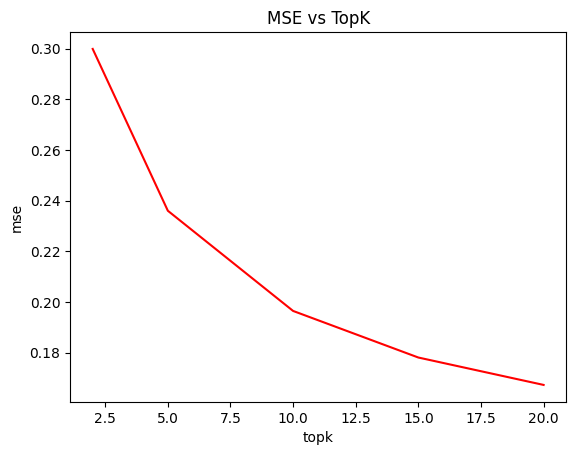

In [53]:
plt.plot(topk_list, mse_list, color='r')
plt.xlabel('topk')
plt.ylabel('mse')
plt.title('MSE vs TopK')

Text(0.5, 1.0, 'MAE vs TopK')

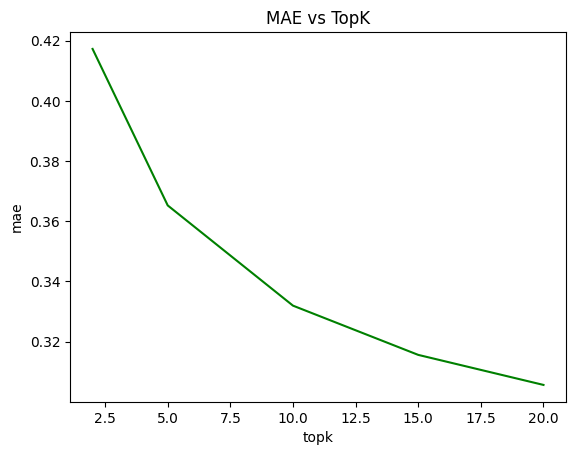

In [54]:
plt.plot(topk_list, mae_list, color='g')
plt.xlabel('topk')
plt.ylabel('mae')
plt.title('MAE vs TopK')